In [1]:
import torch
import logging
import sys

from model.vision_transformer_utils import (
    WarmupCosineSchedule,
    CosineWDSchedule)
from model.vision_transformer_utils import trunc_normal_, init_opt, apply_masks_targets
from model.ijepa_utils import AverageMeter
from model.vision_transformer import VisionTransformer, VisionTransformerPredictor

logging.basicConfig(stream=sys.stdout, level=logging.INFO)
logger = logging.getLogger()



def load_checkpoint(
    device,
    r_path,
    encoder,
    predictor,
    target_encoder,
    opt,
    scaler,
):
    try:
        checkpoint = torch.load(r_path, map_location=torch.device('cpu'))
        epoch = checkpoint['epoch']

        # -- loading encoder
        pretrained_dict = checkpoint['encoder']
        msg = encoder.load_state_dict(pretrained_dict)
        logger.info(f'loaded pretrained encoder from epoch {epoch} with msg: {msg}')

        # -- loading predictor
        pretrained_dict = checkpoint['predictor']
        msg = predictor.load_state_dict(pretrained_dict)
        logger.info(f'loaded pretrained encoder from epoch {epoch} with msg: {msg}')

        # -- loading target_encoder
        if target_encoder is not None:
            print(list(checkpoint.keys()))
            pretrained_dict = checkpoint['target_encoder']
            msg = target_encoder.load_state_dict(pretrained_dict)
            logger.info(f'loaded pretrained encoder from epoch {epoch} with msg: {msg}')

        # -- loading optimizer
        if opt is not None:
            opt.load_state_dict(checkpoint['opt'])
        if scaler is not None:
            scaler.load_state_dict(checkpoint['scaler'])
        logger.info(f'loaded optimizers from epoch {epoch}')
        logger.info(f'read-path: {r_path}')
        del checkpoint

    except Exception as e:
        logger.info(f'Encountered exception when loading checkpoint {e}')
        epoch = 0

    return encoder, predictor, target_encoder, opt, scaler, epoch


In [2]:
def generateMasks(data):
    """
    :param data: tensor of shape [B, R, C, D]
    :returns: (data, 1x masks_enc, 4x masks_pred)
    """
    B, R, C, D = data.size()

    # Initialize masks
    masks_enc = torch.zeros(B, R, C, dtype=torch.uint8)
    masks_pred = torch.zeros(4, B, R, C, dtype=torch.uint8)

    ## select deltas before sample loop. 
    ## grid_size: 20x10
    delta_h_ctxt = torch.randint(6, 10, (1,))        ## low (inclusive), high (exclusive)
    delta_w_ctxt = torch.randint(4, 6, (1,))  
    delta_h_trgt = torch.randint(4, 8, (1,))  
    delta_w_trgt = torch.randint(2, 4, (1,))  
    
    for b in range(B):
        # Select h1, w1 for the encoding mask with constraints
        h1 = torch.randint(0, R, (1,))
        if h1 + delta_h_ctxt > R:
            h1 = R - delta_h_ctxt
        w1 = torch.randint(0, C, (1,))
        if w1 + delta_w_ctxt > C:
            w1 = C - delta_w_ctxt
        
        # Set the encoding mask
        masks_enc[b, h1:h1+delta_h_ctxt, w1:w1+delta_w_ctxt] = 1

        # Generate four prediction masks (can be overlapping with each other, but not with context mask)
        for i in range(4):
            n=0
            while True:
                if n>2000:
                    print(f"cant find valid mask n={n}, stuck...")
                # Smaller random sizes for prediction masks
                h1 = torch.randint(0, R, (1,))
                if h1 + delta_h_trgt > R:
                    h1 = R - delta_h_trgt
                w1 = torch.randint(0, C, (1,))
                if w1 + delta_w_trgt > C:
                    w1 = C - delta_w_trgt

                # Create a temporary mask to check overlap
                temp_mask = torch.zeros(R, C, dtype=torch.bool)
                temp_mask[h1:h1+delta_h_trgt, w1:w1+delta_w_trgt] = 1

                # Check if it overlaps with the encoding mask
                if torch.any(masks_enc[b] & temp_mask):
                    n+=1
                    continue  # Overlaps, try again

                # No overlap, set this mask
                masks_pred[i, b] = temp_mask
                break

    return (data, masks_enc, masks_pred.transpose(0, 1))  


In [11]:
def plot_adj(path, l):
    load_model=True
    import time
    import yaml
    import sys
    import torch
    sys.path.append('.')
    sys.path.append('..')
    from lib.dataloader import get_dataloader
    args = {"data_dir": r"data", "dataset": "NYCTaxi", "batch_size": 32, "test_batch_size": 1, "rows": 20, "cols": 10, "num_epochs": 100}
    dataloader = get_dataloader(
        data_dir=args['data_dir'], 
        dataset=args['dataset'], 
        batch_size=args['batch_size'], 
        test_batch_size=args['test_batch_size'],
        scalar_type='Standard'
    )
    train_loader = dataloader['train']
    test_loader = dataloader['test']
    val_loader = dataloader['val']

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    encoder = VisionTransformer(
            img_size=(args["rows"], args["cols"]),
            patch_size=1,
            in_chans=2,
            embed_dim=8,
            predictor_embed_dim=None,
            depth=1,
            predictor_depth=None,
            num_heads=1,
            mlp_ratio=2,
            qkv_bias=True,
            qk_scale=None,
            drop_rate=0.2,
            attn_drop_rate=0.2,
            drop_path_rate=0.1,
            norm_layer=torch.nn.LayerNorm,
            init_std=0.02
        )
    predictor = VisionTransformerPredictor(
        img_size=(args["rows"], args["cols"]),
        embed_dim=8,
        predictor_embed_dim=8//2,
        depth=1,
        num_heads=1,
        mlp_ratio=2,
        qkv_bias=True,
        qk_scale=None,
        drop_rate=0.2,
        attn_drop_rate=0.2,
        drop_path_rate=0.1,
        norm_layer=torch.nn.LayerNorm,
        init_std=0.02
    )

    import copy
    target_encoder = copy.deepcopy(encoder)
    encoder.eval().to(device)
    predictor.eval().to(device)
    target_encoder.eval().to(device)




    wd = 0.04
    final_wd = 0.4
    start_lr = 0.0002
    final_lr = 1.0e-06
    lr = 0.001
    ipe = len(train_loader)
    warmup = 40
    ipe_scale = 1.0
    use_bfloat16 = True
    optimizer, scaler, scheduler, wd_scheduler = init_opt(
            encoder=encoder,
            predictor=predictor,
            wd=wd,
            final_wd=final_wd,
            start_lr=start_lr,
            ref_lr=lr,
            final_lr=final_lr,
            iterations_per_epoch=ipe,
            warmup=warmup,
            num_epochs=args["num_epochs"],
            ipe_scale=ipe_scale,
            use_bfloat16=use_bfloat16)

    ema = [0.996, 1.0]
    ipe = len(train_loader)
    ipe_scale = 1.0
    momentum_scheduler = (ema[0] + i*(ema[1]-ema[0])/(ipe*args["num_epochs"]*ipe_scale)
                            for i in range(int(ipe*args["num_epochs"]*ipe_scale)+1))
    
    if load_model:
        encoder, predictor, target_encoder, optimizer, scaler, start_epoch = load_checkpoint(
            device=device,
            r_path=path,
            encoder=encoder,
            predictor=predictor,
            target_encoder=target_encoder,
            opt=optimizer,
            scaler=scaler)
        for _ in range(start_epoch*ipe):
            scheduler.step()
            wd_scheduler.step()

            # next(momentum_scheduler)
    ## just get the attention maps from the context_encoder (input whole image)

    with torch.no_grad():
        data, target = next(iter(val_loader))
        # print(len(data))
        # print(data)
        print(f"loaded data, data.shape: {data.shape}")
        data = data[:, 0, :, :].squeeze(1)
        B, N, D = data.size()
        data = data.view(B, args["rows"], args["cols"], D).to(device)
        imgs, masks_enc, masks_pred = generateMasks(data)
        imgs = imgs.permute(0, 3, 1, 2)  # [B, D, R, C]
        masks_pred = masks_pred.flatten(2)  # [B, 4, R*C]
        masks_enc = masks_enc.flatten(1).unsqueeze(1)  # [B, 1, R*C]
        
        """ see whole image as context """
        # masks_enc=torch.ones_like(masks_enc)
        # masks_pred=torch.ones_like(masks_pred)
        # masks_enc=torch.zeros_like(masks_enc)
        # masks_enc[:, :, 0:2] = 1
        def forward_context():    ## mask context tokens before encoding
            z, attn_list = encoder(imgs, masks=masks_enc)  ## VisionTransformer
            return z, attn_list
        def forward_target():
            z, attn_list = target_encoder(imgs, masks=masks_pred)  ## VisionTransformer
            return z, attn_list
        zt, _ = forward_target()  # Target encoder forward pass
        zc, attention_ctxt = forward_context()  # Context encoder forward pass
        zp = predictor(zc, masks_enc, masks_pred)   ## VisionTransformerPredictor
            
            
    # print(len(attention_ctxt))
    # print(attention_ctxt[0].shape)   ## [32, 4, 200, 200]

    import matplotlib.pyplot as plt
    print(f"zp.shape: {zp.shape}, zc.shape: {zc.shape}, zt.shape: {zt.shape}")  ## zp.shape: torch.Size([4, 8, 8]), zc.shape: torch.Size([1, 36, 8]), zt.shape: torch.Size([4, 8, 8])
    # Generate the same 200x200 attention matrix
    # np.random.seed(42)
    # attn1 = attn_list_1[l][0].squeeze(0).softmax(-1).cpu().numpy()[:,:]
    # print(zc.shape)
    zc = zc[0].squeeze(0).cpu().numpy()
    # Create a static heatmap using Matplotlib
    attn = attention_ctxt[0][0].softmax(-1)
    # print(f"attn.shape: {attn.shape}")
    # attn = torch.mean(attn, dim=0)
    # print(f"attn.shape: {attn.shape}")
    import numpy as np
    """save adj"""
    # np.savez("adj_mx", adj_mx=attn[0].cpu().numpy())
    
    plt.figure(figsize=(10, 8))
    # plt.imshow(attn[0], cmap='viridis', aspect='auto')
    plt.matshow(zc, cmap='viridis', aspect='auto')
    plt.colorbar(label='Attention Weight')
    plt.title('Static Attention Matrix Heatmap')
    plt.xlabel('Features')
    plt.ylabel('Features')
    plt.show()
    
    
    zt = zt[0].squeeze(0).cpu().numpy()
    # Create a static heatmap using Matplotlib
    plt.figure(figsize=(10, 8))
    plt.matshow(zt, cmap='viridis', aspect='auto')
    plt.colorbar(label='Attention Weight')
    plt.title('Static Attention Matrix Heatmap')
    plt.xlabel('Features')
    plt.ylabel('Features')
    plt.show()

    zp = zp[0].squeeze(0).cpu().numpy()
    # Create a static heatmap using Matplotlib
    plt.figure(figsize=(10, 8))
    plt.matshow(zp, cmap='viridis', aspect='auto')
    plt.colorbar(label='Attention Weight')
    plt.title('Static Attention Matrix Heatmap')
    plt.xlabel('Features')
    plt.ylabel('Features')
    plt.show()
    
# for i in range(10, 501, 10):

#     load_path = fr"D:\omer\ST-SSL\logs\singleBLK_dim8_biggerPatches\jepa-ep{i}.pth.tar"
#     plot_adj(load_path, 0)

::Scaling is NOT off::
data['x_train'].shape:  (1912, 35, 200, 2) (1912, 1, 200, 2)
INFO:root:Using AdamW
INFO:root:loaded pretrained encoder from epoch 83 with msg: <All keys matched successfully>
INFO:root:loaded pretrained encoder from epoch 83 with msg: <All keys matched successfully>
['encoder', 'predictor', 'target_encoder', 'opt', 'scaler', 'epoch', 'loss', 'batch_size', 'world_size', 'lr']
INFO:root:loaded pretrained encoder from epoch 83 with msg: <All keys matched successfully>
INFO:root:loaded optimizers from epoch 83
INFO:root:read-path: E:\estudy\ST-SSL\code\ST-SSL\logs\jepa-ep84.pth.tar
loaded data, data.shape: torch.Size([1, 35, 200, 2])
zp.shape: torch.Size([4, 8, 8]), zc.shape: torch.Size([1, 36, 8]), zt.shape: torch.Size([4, 8, 8])


C:\Users\omera\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\torch\cuda\amp\grad_scaler.py:118: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn("torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.")


<Figure size 1000x800 with 0 Axes>

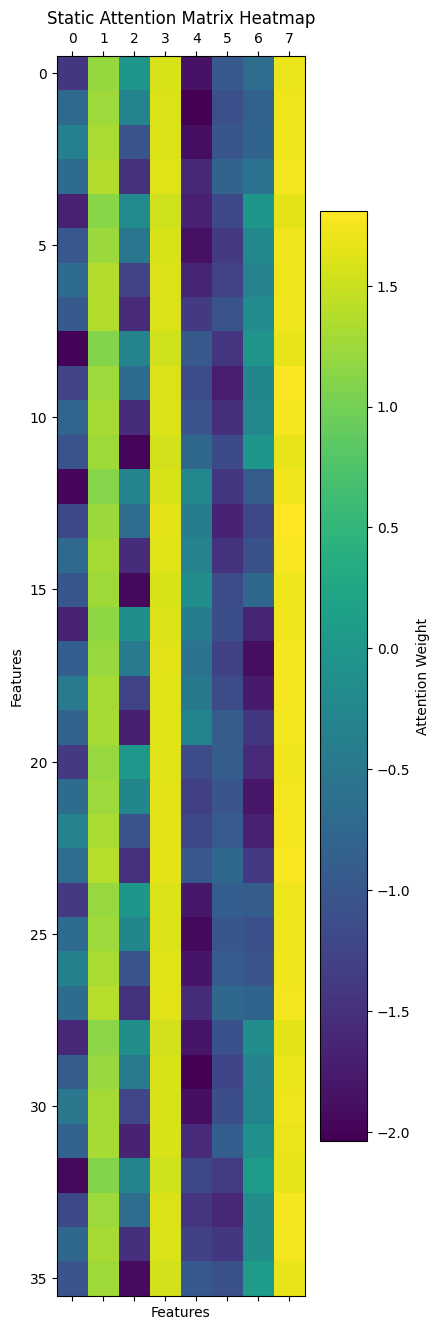

<Figure size 1000x800 with 0 Axes>

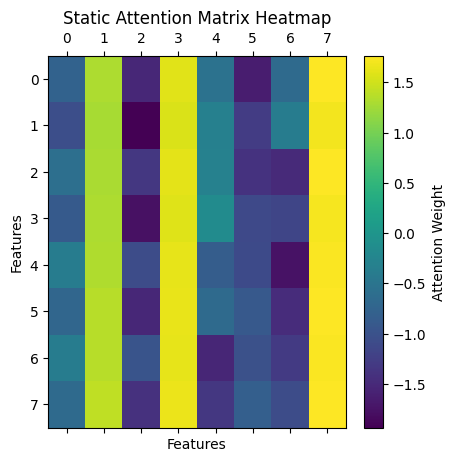

<Figure size 1000x800 with 0 Axes>

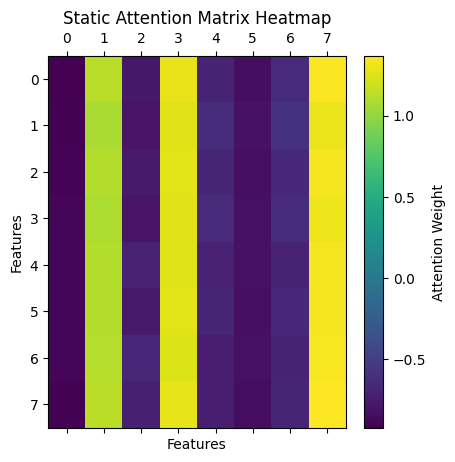

In [12]:
i=22
# load_path = fr"E:\estudy\ST-SSL\code\ST-SSL\logs\singleBLK_dim8_biggerPatches\jepa-ep{i}.pth.tar"
load_path = fr"E:\estudy\ST-SSL\code\ST-SSL\logs\jepa-ep84.pth.tar"
# for l in range(4): plot_adj(load_path, l)
plot_adj(load_path, 0)

::Scaling is NOT off::
data['x_train'].shape:  (1912, 35, 200, 2) (1912, 1, 200, 2)
INFO:root:Using AdamW
INFO:root:loaded pretrained encoder from epoch 41 with msg: <All keys matched successfully>
INFO:root:loaded pretrained encoder from epoch 41 with msg: <All keys matched successfully>
['encoder', 'predictor', 'target_encoder', 'opt', 'scaler', 'epoch', 'loss', 'batch_size', 'world_size', 'lr']
INFO:root:loaded pretrained encoder from epoch 41 with msg: <All keys matched successfully>
INFO:root:loaded optimizers from epoch 41
INFO:root:read-path: E:\estudy\ST-SSL\code\ST-SSL\logs\singleBLK_dim8_biggerPatches\jepa-ep42.pth.tar
attn.shape: torch.Size([1, 24, 24])
attn.shape: torch.Size([1, 24, 24])


<Figure size 1000x800 with 0 Axes>

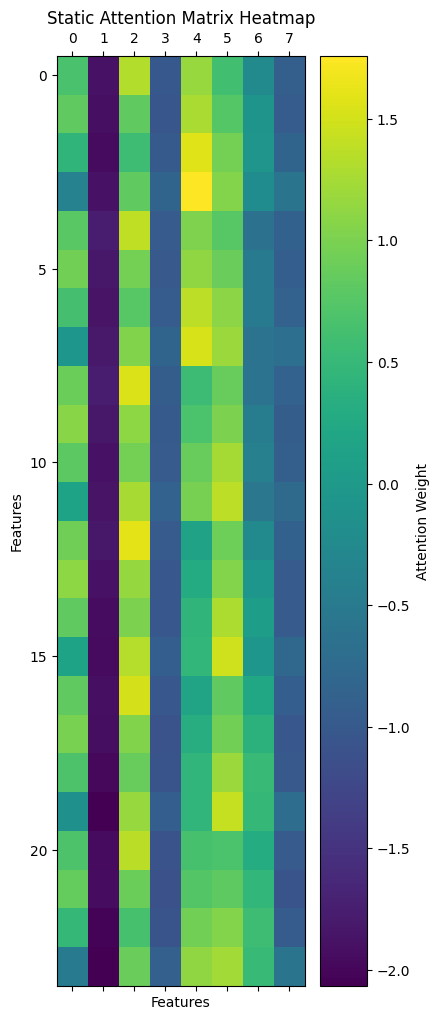

<Figure size 1000x800 with 0 Axes>

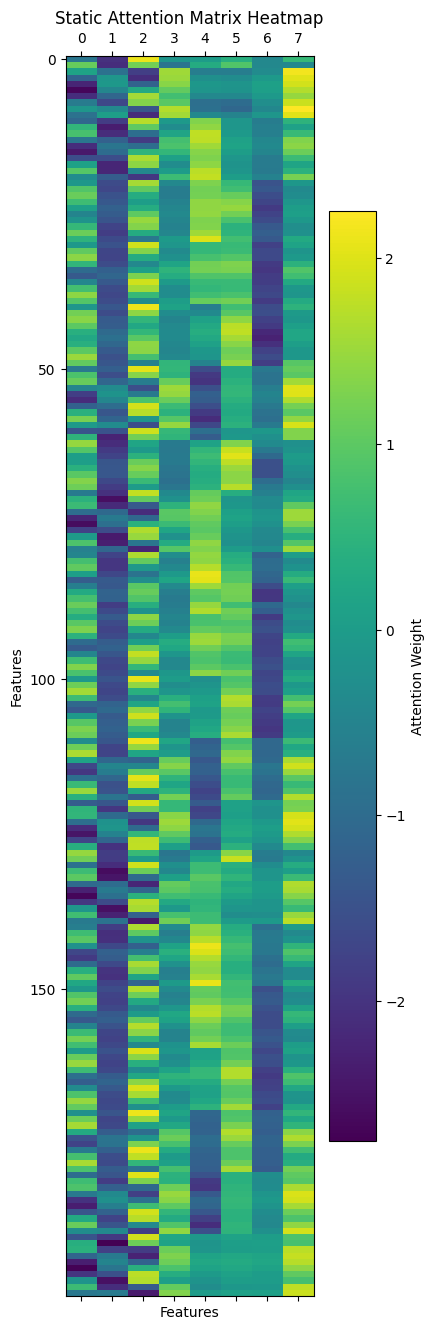

<Figure size 1000x800 with 0 Axes>

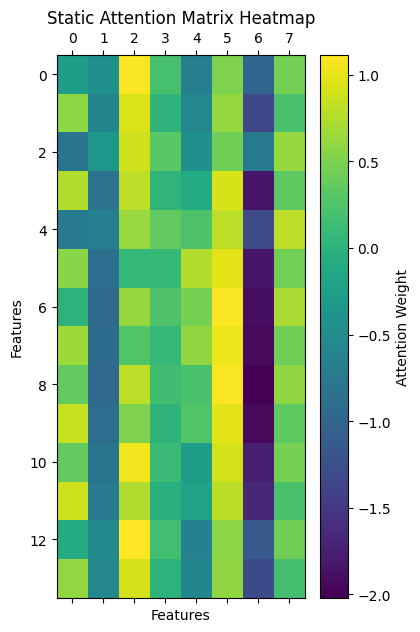

In [72]:
i=42
load_path = fr"E:\estudy\ST-SSL\code\ST-SSL\logs\singleBLK_dim8_biggerPatches\jepa-ep{i}.pth.tar"
# for l in range(4): plot_adj(load_path, l)
plot_adj(load_path, 0)

In [67]:
s = 'asfg'
t = 'zszz'

result = [s[i] for i, char in enumerate(t) if char == 's']
print(result)
s = 'asfg'
t = 'sad'
print(s[t=="f"])
result = [s[i] for i in range(len(s)) if s[i] == t]
print(result)

['s']
a
[]
